<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- DREAMER veri setini yükleme fonksiyonu ---
def load_dreamer_data(file_path):
    data = sio.loadmat(file_path)
    eeg_data = []
    labels = []
    for participant in range(23):
        for video in range(18):
            stimuli = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0]
            if stimuli.size == 0:
                continue
            if stimuli.shape[0] != 14:
                stimuli = stimuli.T
            eeg_data.append(stimuli)
            valence_score = data['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0]
            labels.append(valence_score)
    return eeg_data, np.array(labels)

In [4]:
# --- EEG verilerini ön işleme fonksiyonu ---
def preprocess_eeg_data(eeg_data, max_length=1000):
    padded_eeg_data = []
    for sample in eeg_data:
        if sample.shape[1] < max_length:
            padding_shape = ((0, 0), (0, max_length - sample.shape[1]))
            padded_sample = np.pad(sample, padding_shape, mode='constant', constant_values=0)
        else:
            padded_sample = sample[:, :max_length]
        padded_eeg_data.append(padded_sample)
    eeg_data = np.array(padded_eeg_data)
    scaler = StandardScaler()
    eeg_data = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data = scaler.fit_transform(eeg_data)
    eeg_data = eeg_data.reshape(-1, max_length, 14)
    return eeg_data

In [5]:
# --- RNN modeli tanımı ---
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(128, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.03)),
        BatchNormalization(),
        Dropout(0.6),
        SimpleRNN(64, return_sequences=False, kernel_regularizer=l2(0.03)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(32, activation='relu', kernel_regularizer=l2(0.03)),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])
    return model

In [6]:
# Veri yolu
file_path = "/content/drive/MyDrive/Colab Notebooks/DREAMER.mat"

In [7]:
# Veri setini yükleme
eeg_data, labels = load_dreamer_data(file_path)

In [8]:
# Veri ön işleme
eeg_data = preprocess_eeg_data(eeg_data)

In [9]:
# Etiketleri binary hale getirme
labels = LabelEncoder().fit_transform(labels > 5)  # Valence > 5 -> 1, aksi takdirde 0

In [10]:
# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.3, random_state=42)

In [11]:
# Sınıf ağırlıklarını hesaplama
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [12]:
# Modeli oluşturma
model = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Callbacks: Erken durdurma
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
# Modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 703ms/step - accuracy: 0.3681 - loss: 6.1141 - val_accuracy: 0.4800 - val_loss: 5.3353
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 913ms/step - accuracy: 0.3719 - loss: 6.2192 - val_accuracy: 0.5200 - val_loss: 5.3136
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step - accuracy: 0.4133 - loss: 6.0857 - val_accuracy: 0.4880 - val_loss: 5.3061
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 924ms/step - accuracy: 0.4095 - loss: 6.0236 - val_accuracy: 0.4720 - val_loss: 5.2906
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 651ms/step - accuracy: 0.3682 - loss: 6.0923 - val_accuracy: 0.4560 - val_loss: 5.2854
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 915ms/step - accuracy: 0.4348 - loss: 5.9159 - val_accuracy: 0.4640 - val_loss: 5.2690
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 698ms/step - accuracy: 0.4770 - loss: 5.8572 - val_accuracy: 0.4640 - val_loss: 5.2488
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 662ms/step - accuracy: 0.4949 - loss: 5.8044 - val_accuracy: 

In [15]:
# --- Test ---
test_logits = model.predict(X_test)
test_accuracy = tf.keras.metrics.BinaryAccuracy()(y_test, test_logits)
print(f"Test Accuracy: {test_accuracy.numpy():.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Test Accuracy: 0.9680


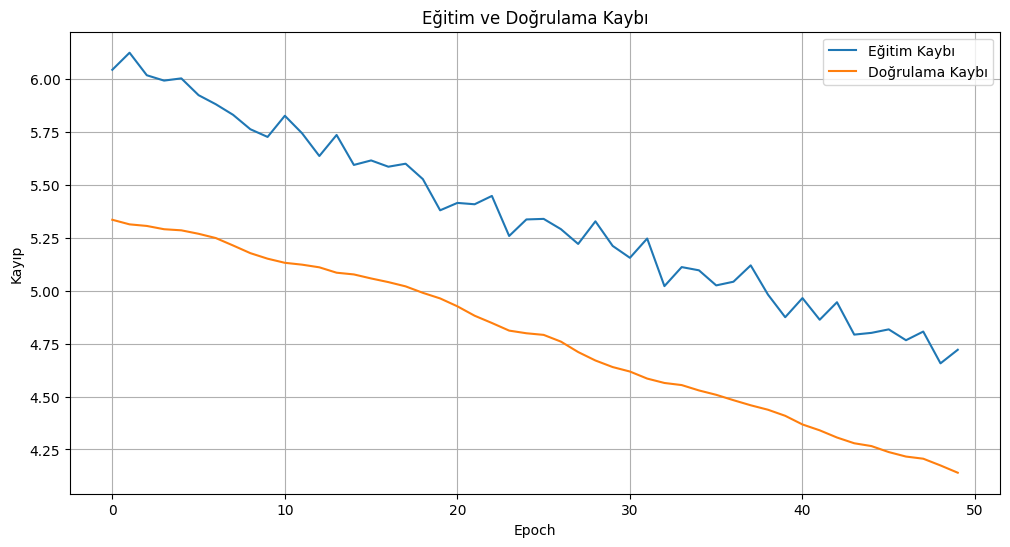

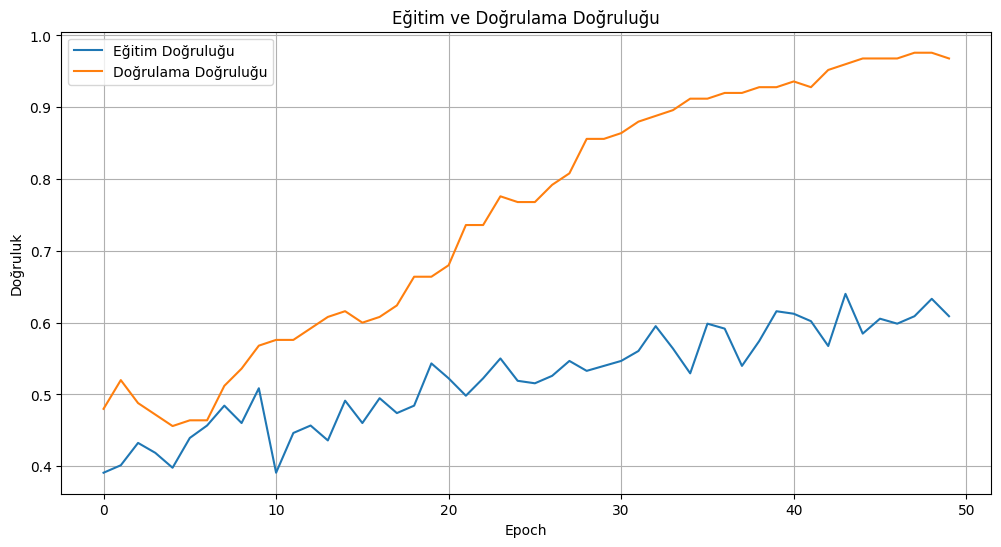

In [16]:
# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid()
plt.title("Eğitim ve Doğrulama Kaybı")
plt.show()

# Eğitim ve doğrulama doğruluklarını çizme
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid()
plt.title("Eğitim ve Doğrulama Doğruluğu")
plt.show()